<a href="https://colab.research.google.com/github/KangaOnGit/Transformer-Revision/blob/main/Vision_Transformer_(ViT)_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch import nn
import os
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# Download dataset
!gdown 1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc
!unzip ./flower_photos.zip

Downloading...
From (original): https://drive.google.com/uc?id=1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc
From (redirected): https://drive.google.com/uc?id=1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc&confirm=t&uuid=753356d1-58eb-494a-a326-b708b77d0797
To: /content/flower_photos.zip
100% 230M/230M [00:02<00:00, 109MB/s]
Archive:  ./flower_photos.zip
   creating: flower_photos/
   creating: flower_photos/daisy/
  inflating: flower_photos/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flower_photos/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flower_photos/daisy/10172379554_b296050f82_n.jpg  
  inflating: flower_photos/daisy/10172567486_2748826a8b.jpg  
  inflating: flower_photos/daisy/10172636503_21bededa75_n.jpg  
  inflating: flower_photos/daisy/102841525_bd6628ae3c.jpg  
  inflating: flower_photos/daisy/1031799732_e7f4008c03.jpg  
  inflating: flower_photos/daisy/10391248763_1d16681106_n.jpg  
  inflating: flower_photos/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flower_photos/daisy/1043777054

In [3]:
# Load dataset
data_path = "./flower_photos"
dataset = ImageFolder(root=data_path)
num_samples = len(dataset)
classes = dataset.classes
num_classes = len(classes)

In [4]:
# Split dataset into train/valid/test
TRAIN_RATIO, VALID_RATIO = 0.8, 0.1
n_train_examples = int(num_samples * TRAIN_RATIO)
n_valid_examples = int(num_samples * VALID_RATIO)
n_test_examples = num_samples - n_train_examples - n_valid_examples

train_dataset, valid_dataset, test_dataset = random_split(
    dataset,
    [n_train_examples, n_valid_examples, n_test_examples]
)

In [5]:
# Resize images and normalize
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Apply transforms to datasets
train_dataset.dataset.transform = train_transforms
valid_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

In [6]:
BATCH_SIZE = 512

train_loader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE
)

val_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)

In [7]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2


class PatchPositionEmbedding(nn.Module):
    def __init__(self, image_size=224, embed_dim=512, patch_size=16, device='cpu'):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
            bias=False
        )
        scale = embed_dim ** -0.5
        self.positional_embedding = nn.Parameter(
            scale * torch.randn((image_size // patch_size) ** 2, embed_dim)
        )
        self.device = device

    def forward(self, x):
        x = self.conv1(x)
        x = x.reshape(x.shape[0], x.shape[1], -1)
        x = x.permute(0, 2, 1)
        x = x + self.positional_embedding.to(self.device)
        return x


class VisionTransformerCls(nn.Module):
    def __init__(self, image_size, embed_dim, num_heads, ff_dim, dropout=0.1, device='cpu', num_classes=10, patch_size=16):
        super().__init__()
        self.embd_layer = PatchPositionEmbedding(
            image_size=image_size, embed_dim=embed_dim, patch_size=patch_size, device=device
        )
        self.transformer_layer = TransformerEncoder(embed_dim, num_heads, ff_dim, dropout)
        self.fc1 = nn.Linear(embed_dim, 20)
        self.fc2 = nn.Linear(20, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.embd_layer(x)
        output = self.transformer_layer(output, output, output)
        output = output[:, 0, :]
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

In [8]:
# Train epoch
def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(inputs)

        # Compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # Backward
        loss.backward()
        optimizer.step()

        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

# Evaluate epoch
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for inputs, labels in valid_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [9]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = float('inf')
    times = []

    for epoch in range(1, num_epochs + 1):
        epoch_start_time = time.time()

        # Training
        train_acc, train_loss = train_epoch(
            model, optimizer, criterion, train_dataloader, device, epoch
        )
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(
            model, criterion, valid_dataloader, device
        )
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')
            best_loss_eval = eval_loss

        times.append(time.time() - epoch_start_time)

        # Print loss and accuracy
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()

    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }

    return model, metrics

In [10]:
# Define hyperparameters
image_size = 224
embed_dim = 512
num_heads = 4
ff_dim = 128
dropout = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformerCls(
    image_size=image_size, embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout,
    num_classes=num_classes, device=device
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 100
save_model = './vit_flowers'
os.makedirs(save_model, exist_ok=True)
model_name = 'vit_flowers'

# Train model
model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_loader, val_loader, num_epochs, device
)

-----------------------------------------------------------
| End of epoch   1 | Time: 18.69s | Train Accuracy    0.287 | Train Loss    1.737 | Valid Accuracy    0.379 | Valid Loss    1.439 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   2 | Time: 15.62s | Train Accuracy    0.354 | Train Loss    1.452 | Valid Accuracy    0.401 | Valid Loss    1.408 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   3 | Time: 15.59s | Train Accuracy    0.383 | Train Loss    1.385 | Valid Accuracy    0.401 | Valid Loss    1.337 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   4 | Time: 16.39s | Train Accuracy    0.422 | Train Loss    1.301 | Valid Accuracy    0.447 | Valid Loss    1.265 
--------------------------------------------------------

<ipython-input-9-06b27daf0d44>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))


In [11]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(1, num_epochs + 1))

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Plot accuracy
    axs[0].plot(epochs, train_accs, label="Training Accuracy")
    axs[0].plot(epochs, eval_accs, label="Validation Accuracy")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()
    axs[0].set_title("Accuracy vs Epochs")

    # Plot loss
    axs[1].plot(epochs, train_losses, label="Training Loss")
    axs[1].plot(epochs, eval_losses, label="Validation Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    axs[1].set_title("Loss vs Epochs")

    plt.tight_layout()
    plt.show()

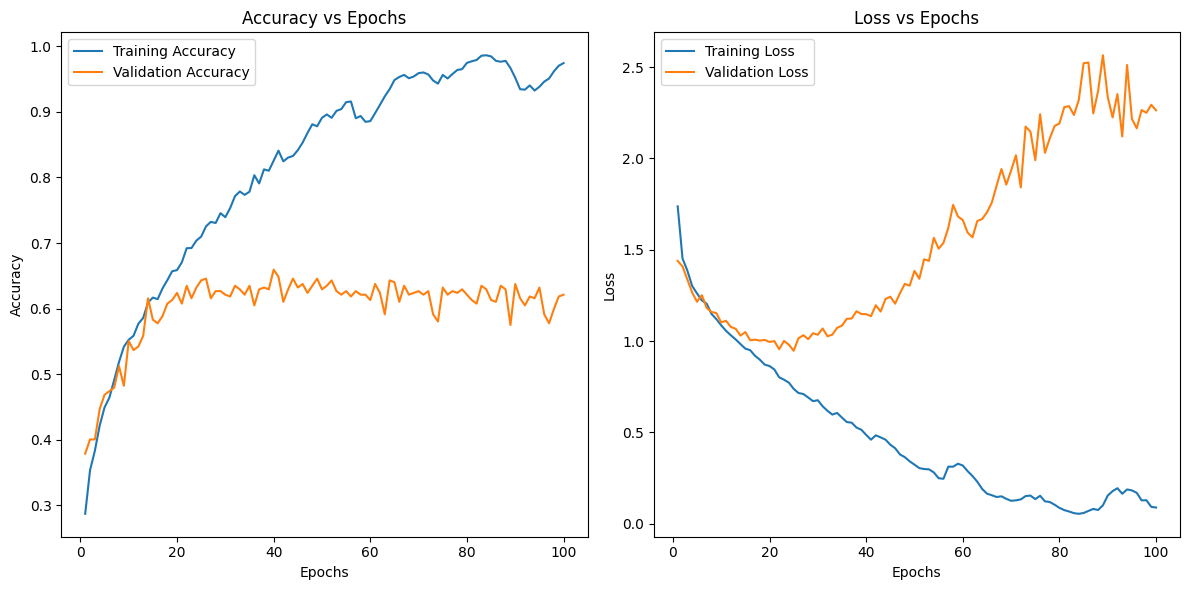

In [12]:
plot_result(num_epochs, metrics['train_accuracy'],
            metrics['valid_accuracy'], metrics['train_loss'], metrics['valid_loss'])

# **Fine Tuning**

In [13]:
from transformers import ViTForImageClassification

id2label = {id: label for id, label in enumerate(classes)}
label2id = {label: id for id, label in id2label.items()}

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [15]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [16]:
import evaluate
import numpy as np

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [17]:
from transformers import ViTImageProcessor, TrainingArguments, Trainer

feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

args = TrainingArguments(
    "vit_flowers",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs',
    remove_unused_columns=False,
)

def collate_fn(examples):
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-72715044098f>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [18]:
trainer.train()
outputs = trainer.predict(test_dataset)
outputs.metrics

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.509950,0.980926
2,No log,0.224709,0.983651
3,No log,0.162290,0.980926
4,No log,0.149507,0.975477
5,No log,0.129092,0.978202
6,0.320700,0.123120,0.980926
7,0.320700,0.122514,0.975477
8,0.320700,0.118742,0.975477
9,0.320700,0.117891,0.972752
10,0.320700,0.117500,0.972752


{'test_loss': 0.27314576506614685,
 'test_accuracy': 0.9564032697547684,
 'test_runtime': 5.9403,
 'test_samples_per_second': 61.782,
 'test_steps_per_second': 2.02}

In [19]:
print(outputs.metrics)

{'test_loss': 0.27314576506614685, 'test_accuracy': 0.9564032697547684, 'test_runtime': 5.9403, 'test_samples_per_second': 61.782, 'test_steps_per_second': 2.02}


In [20]:
print(outputs.metrics.keys())

dict_keys(['test_loss', 'test_accuracy', 'test_runtime', 'test_samples_per_second', 'test_steps_per_second'])
